## 1. 필요한 패키지들을 불러옵니다.

In [1]:
import os
BASE_PATH = os.path.dirname(os.getcwd())
os.chdir(BASE_PATH)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.models import load_model

In [4]:
from utils.helper import cropper, glob_all_files, paths2numpy, draw_rectangles

## 2. 학습 시킨 모델을 불러옵니다

In [5]:
# 모델을 불러옵니다. 
model = load_model('./models/book1_model')
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 36, 36, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 36, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 36, 36, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 36, 36, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 18, 64)       

## 3. 평가용 데이터를 불러옵니다.

In [6]:
# 평가에 사용될 월리 책 번호
book_number = 1

In [7]:
paths = glob_all_files(f"./data/book{str(book_number)}/common/full_image_test")

imgs = paths2numpy(paths)

bucket_crop_imgs = []
bucket_crop_crds = []

for img in imgs:
    cropped_images, cropped_coords = cropper(img, 10, 10, 36, 36)
    bucket_crop_imgs.append(cropped_images)
    bucket_crop_crds.append(cropped_coords)

## 4. 모델을 평가용 데이터로 테스트합니다.

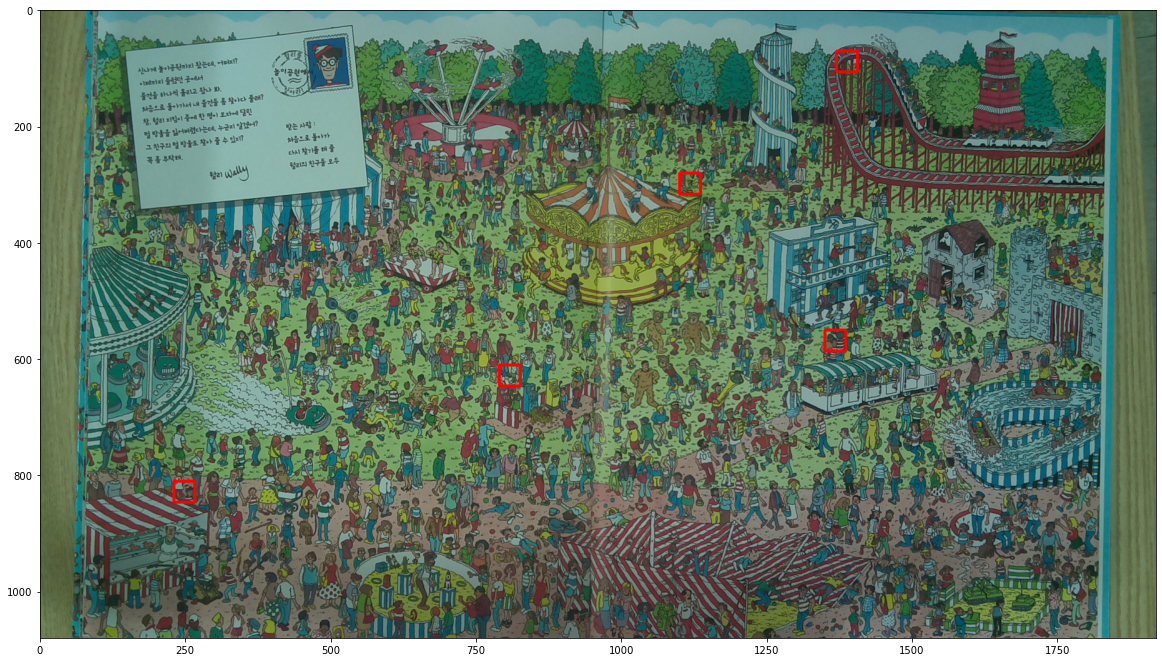

In [9]:
# 모델이 배경이 아니라고 예측한 카테고리 부분에 사각형을 그려주는 부분입니다.
for i, img in enumerate(imgs):
    cropped_imgs = bucket_crop_imgs[i]
    cropped_crds = bucket_crop_crds[i]

    # 예측값을 저장한 후, 그 중 0.5가 넘는 값들에 대한 불리언 마스크를 만드는 부분입니다.
    predicts = model.predict(cropped_imgs)

    # 불리언 마스크를 만들어 적용시키기 위한 부분
    # np.argsort(predicts)[:, -1] 이후,
    """
    != 0: 배경을 제외한 나머지 캐릭터들로 예측되는 곳은 true
    == 1: 월리로 예측되는 곳만 true
    == 2: 여자친구로 예측되는 곳만 true
    == 3: 마법사로 예측되는 곳만 true
    == 4: 가짜로 예측되는 곳만 true
    """
    bool_mask = (np.argsort(predicts)[:, -1] != 0)

    # show_images(cropped_imgs[bool_mask])    # 불리언 마스크를 적용시킨 결과로 얻은 월리의 얼굴로 추정되는 이미지 조각들을 출력
    target_crds = np.array(cropped_crds)[bool_mask]     # 월리의 얼굴이 있을 것으로 예상되는 좌표들을 저장

    predicts = predicts[bool_mask]  # 불리언 마스크를 적용시켰을 때의 예측값을 저장
    
    predicts = np.max(predicts, axis=1)

    result_image = draw_rectangles(img, target_crds, (255, 0, 0), 3, predicts)

    plt.figure(figsize=(20, 20))
    plt.imshow(result_image)
    plt.show()


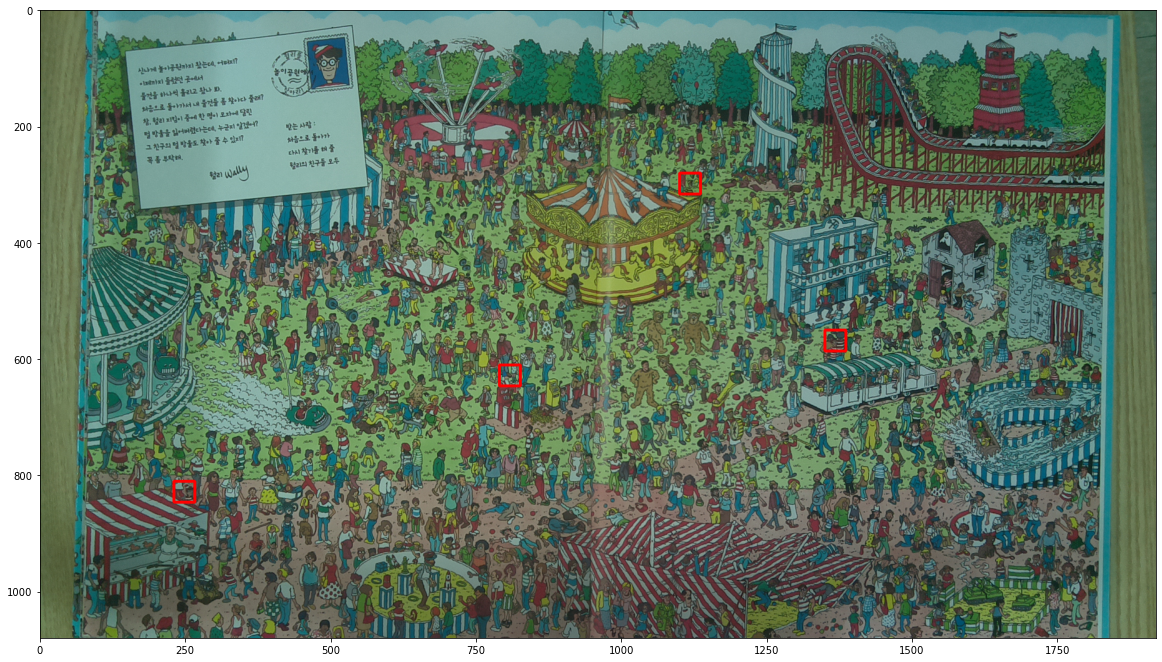

In [8]:
# 9. 모델을 검증용 데이터로 테스트합니다.
for i, img in enumerate(imgs):
    cropped_imgs = bucket_crop_imgs[i]
    cropped_crds = bucket_crop_crds[i]

    # 예측값을 저장한 후, 그 중 0.5가 넘는 값들에 대한 불리언 마스크를 만드는 부분입니다.
    predicts = model.predict(cropped_imgs)
    
    # **test, 특정 오브젝트의 max 예측값의 인덱스를 받아와 출력하기 위한 부분
    waly_max = np.where(predicts[:, 1] == np.max(predicts[:, 1]))
    girl_max = np.where(predicts[:, 2] == np.max(predicts[:, 2]))
    magi_max = np.where(predicts[:, 3] == np.max(predicts[:, 3]))
    fake_max = np.where(predicts[:, 4] == np.max(predicts[:, 4]))
    
    # 모든 오브젝트의 max 예측값의 인덱스를 가져오는 부분
    all_max = np.argsort(predicts*-1, axis=0)[0, 1:5]
    
    # 찾고자 하는 캐릭터의 얼굴이 있을 것으로 예상되는 좌표들을 저장
    # [] 안에 넣는 값에 따라 찾고자 하는 캐릭터가 바뀌게 됩니다. 
    """
    waly_max = 월리
    girl_max = 월리 여자친구
    magi_max = 마법사
    fake_max = 가짜 월리
    all_max = 위의 모든 캐릭터들
    """
    target_crds = np.array(cropped_crds)[all_max]
    
    predicts = predicts[all_max]  # 불리언 마스크를 적용시켰을 때의 예측값을 저장

    # 각 행들의 최대 예측값을 저장
    predicts = np.max(predicts, axis=1)

    result_image = draw_rectangles(img, target_crds, (255, 0, 0), 3, predicts)

    plt.figure(figsize=(20, 20))
    plt.imshow(result_image)
    plt.show()